## Covid 19 Prediction
### By Doaa Ahmed

### Intorduction

* [Step 0](#step0): Import Dataset
* [Step 1](#step1): Split the data set
* [Step 2](#step2): Creat Data Loaders
* [Step 3](#step3): Creat Train Function
* [Step 4](#step4): Create Test Function
* [Step 5](#step5): Creat Model
* [Step 6](#step6): Set Hyper Parameters
* [Step 7](#step7): Train The model
* [Step 8](#step8): Test The model accuracy

<a id='step0'></a>
## Step 0: Import Dataset

### Import the Data

In [2]:
import numpy as np
from glob import glob

# load filenames for all images
all_files = np.array(glob("./images_2/*/*/*"))


# print number of images in the dataset
print('There are %d total  images, with covid-19 and non covid-19 cases' % len(all_files))


There are 1986 total  images, with covid-19 and non covid-19 cases


<a id='step1'></a>
## Step 1: Split the data set

Here I have splitted the available data into test(10%), train(80%) and validation(10%)

In [3]:
import splitfolders

data_dir = './images_2/ct_data'
splitfolders.ratio(data_dir, output="./splitted_Data_2", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 1986 files [00:09, 213.84 files/s]


<a id='step2'></a>
## Step 2: Creat Data Loaders

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import torch


num_workers = 0


#batch size
batch_size = 20

#convert the data to a normalized tensor
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomVerticalFlip(),                                       
    #transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    #transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    #transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
    ])

data_dir = 'splitted_Data_2/'

train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'val/')


train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=train_transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

#prepare a dict for all loaders
loaders ={}
loaders['train'] = train_loader
loaders['test'] = test_loader
loaders['valid'] = valid_loader

# get available classes, to be used as the output
classes = []
for cl in train_data.classes:
    classes.append(cl)
print(classes)

print("Number of avaialable classes: " , len(classes))



['CT_COVID', 'CT_NonCOVID']
Number of avaialable classes:  2


<a id='step3'></a>
## Step 3: Create Train Function

In [25]:
#define training function
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    #load previous model if it exists, to save time
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    valid_loss_min = 0.052629
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            #clear optimizer
            optimizer.zero_grad()
        
            #compute predicted op
            output = model(data)
        
            #calculate error/loss for this batch
            loss = criterion(output, target)   
            loss.backward()        
            optimizer.step()
            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #train_loss += loss.item() * data.size(0) #multiply by batch size
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            loss = criterion(output, target)
            
            #in validation we don't do backward propagation
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            #valid_loss += loss.item()* data.size(0)

        #train_loss = train_loss / len(loaders['train'].dataset)
        #valid_loss = valid_loss / len(loaders['valid'].dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("validation loss decreased {:.6f} --> {:.6f} . saving model .. ".format(valid_loss_min, valid_loss))
            torch.save(model.state_dict() , save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

<a id='step4'></a>
## Step 4: Creat Test Function

In [6]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



<a id='step5'></a>
## Step 5: Creat Model

##### Create AlexNet Model

In [7]:
import torch
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Using cache found in C:\Users\DMohamed31/.cache\torch\hub\pytorch_vision_v0.6.0


In [8]:
import torchvision.models as models
import torch.nn as nn

# check if CUDA is available
use_cuda = torch.cuda.is_available()


# print out the model structure
print(AlexNet_model)

for param in AlexNet_model.features.parameters():
    param.requires_grad = False 

#Updating the second classifier
AlexNet_model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 2 output nodes 
AlexNet_model.classifier[6] = nn.Linear(1024,2)


#lexNet_model.classifier[6] = nn.Linear(4096,2)

# check to see that your last layer produces the expected number of outputs
print("output after replacing last layer: ")
print(AlexNet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
import torch.optim as optim
import torch.nn as nn

n_epochs =250
learning_rate = 0.0001

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=learning_rate, momentum=0.9)

In [11]:
AlexNet_model = train(n_epochs, loaders, AlexNet_model, optimizer, criterion, use_cuda, 'Model_AlexNet_Covid19_4.pt')


Epoch: 1 	Training Loss: 0.905489 	Validation Loss: 0.641067
validation loss decreased inf --> 0.641067 . saving model .. 
Epoch: 2 	Training Loss: 0.576117 	Validation Loss: 0.632742
validation loss decreased 0.641067 --> 0.632742 . saving model .. 
Epoch: 3 	Training Loss: 0.502165 	Validation Loss: 0.538483
validation loss decreased 0.632742 --> 0.538483 . saving model .. 
Epoch: 4 	Training Loss: 0.459768 	Validation Loss: 0.506848
validation loss decreased 0.538483 --> 0.506848 . saving model .. 
Epoch: 5 	Training Loss: 0.453221 	Validation Loss: 0.472303
validation loss decreased 0.506848 --> 0.472303 . saving model .. 
Epoch: 6 	Training Loss: 0.430762 	Validation Loss: 0.450716
validation loss decreased 0.472303 --> 0.450716 . saving model .. 
Epoch: 7 	Training Loss: 0.410656 	Validation Loss: 0.412393
validation loss decreased 0.450716 --> 0.412393 . saving model .. 
Epoch: 8 	Training Loss: 0.410433 	Validation Loss: 0.446191
Epoch: 9 	Training Loss: 0.420867 	Validation Lo

Epoch: 105 	Training Loss: 0.170493 	Validation Loss: 0.189310
Epoch: 106 	Training Loss: 0.156366 	Validation Loss: 0.197135
Epoch: 107 	Training Loss: 0.155541 	Validation Loss: 0.181286
Epoch: 108 	Training Loss: 0.157172 	Validation Loss: 0.166175
Epoch: 109 	Training Loss: 0.176620 	Validation Loss: 0.172445
Epoch: 110 	Training Loss: 0.164778 	Validation Loss: 0.163829
validation loss decreased 0.165992 --> 0.163829 . saving model .. 
Epoch: 111 	Training Loss: 0.140944 	Validation Loss: 0.191635
Epoch: 112 	Training Loss: 0.138757 	Validation Loss: 0.168128
Epoch: 113 	Training Loss: 0.161211 	Validation Loss: 0.186375
Epoch: 114 	Training Loss: 0.155013 	Validation Loss: 0.169305
Epoch: 115 	Training Loss: 0.135861 	Validation Loss: 0.178353
Epoch: 116 	Training Loss: 0.160533 	Validation Loss: 0.162390
validation loss decreased 0.163829 --> 0.162390 . saving model .. 
Epoch: 117 	Training Loss: 0.154448 	Validation Loss: 0.163044
Epoch: 118 	Training Loss: 0.143052 	Validation

Epoch: 224 	Training Loss: 0.075678 	Validation Loss: 0.122189
Epoch: 225 	Training Loss: 0.081669 	Validation Loss: 0.113716
Epoch: 226 	Training Loss: 0.078236 	Validation Loss: 0.148995
Epoch: 227 	Training Loss: 0.092147 	Validation Loss: 0.115066
Epoch: 228 	Training Loss: 0.072972 	Validation Loss: 0.095835
validation loss decreased 0.103565 --> 0.095835 . saving model .. 
Epoch: 229 	Training Loss: 0.072495 	Validation Loss: 0.110261
Epoch: 230 	Training Loss: 0.070906 	Validation Loss: 0.101074
Epoch: 231 	Training Loss: 0.090061 	Validation Loss: 0.112745
Epoch: 232 	Training Loss: 0.084931 	Validation Loss: 0.121318
Epoch: 233 	Training Loss: 0.091622 	Validation Loss: 0.117704
Epoch: 234 	Training Loss: 0.067021 	Validation Loss: 0.141895
Epoch: 235 	Training Loss: 0.079125 	Validation Loss: 0.143146
Epoch: 236 	Training Loss: 0.069870 	Validation Loss: 0.133739
Epoch: 237 	Training Loss: 0.082236 	Validation Loss: 0.144745
Epoch: 238 	Training Loss: 0.087293 	Validation Los

In [21]:
#increasing lr
n_epochs =100
learning_rate = 0.001

optimizer = optim.SGD(AlexNet_model.parameters(), lr=learning_rate, momentum=0.9)

In [22]:
AlexNet_model = train(n_epochs, loaders, AlexNet_model, optimizer, criterion, use_cuda, 'Model_AlexNet_Covid19_4.pt')


Epoch: 1 	Training Loss: 0.181504 	Validation Loss: 0.434115
Epoch: 2 	Training Loss: 0.205510 	Validation Loss: 0.171701
Epoch: 3 	Training Loss: 0.167467 	Validation Loss: 0.174221
Epoch: 4 	Training Loss: 0.134643 	Validation Loss: 0.141058
Epoch: 5 	Training Loss: 0.139881 	Validation Loss: 0.139714
Epoch: 6 	Training Loss: 0.114029 	Validation Loss: 0.159672
Epoch: 7 	Training Loss: 0.124098 	Validation Loss: 0.188594
Epoch: 8 	Training Loss: 0.121031 	Validation Loss: 0.147850
Epoch: 9 	Training Loss: 0.134122 	Validation Loss: 0.168225
Epoch: 10 	Training Loss: 0.128249 	Validation Loss: 0.172388
Epoch: 11 	Training Loss: 0.129021 	Validation Loss: 0.129605
Epoch: 12 	Training Loss: 0.090521 	Validation Loss: 0.126219
Epoch: 13 	Training Loss: 0.089648 	Validation Loss: 0.141608
Epoch: 14 	Training Loss: 0.080546 	Validation Loss: 0.151341
Epoch: 15 	Training Loss: 0.098310 	Validation Loss: 0.141277
Epoch: 16 	Training Loss: 0.109420 	Validation Loss: 0.180022
Epoch: 17 	Traini

In [23]:
# load the model that got the best validation accuracy 
AlexNet_model.load_state_dict(torch.load('Model_AlexNet_Covid19_4.pt'))

<All keys matched successfully>

In [24]:
test(loaders, AlexNet_model, criterion, use_cuda)

Test Loss: 0.098723


Test Accuracy: 95% (190/200)


In [145]:
from PIL import Image
import torchvision.transforms as transforms
import cv2

def Model_predict(img_path):
    
    # VGG-16 Takes 224x224 images as input
    data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    ])
    

    
    transformed_img = data_transform(Image.open(img_path).convert('RGB'))
    #make the tensor 4D, instead of 3D
    transformed_img = transformed_img.unsqueeze(0)
    
    if use_cuda:
        transformed_img = transformed_img.cuda()
        
    output = AlexNet_model(transformed_img)
    
    if use_cuda:
        output = output.cpu()
        
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    #print(preds)

    pred_class = classes[preds]
        
    print("Predicted Class : " , pred_class)


In [146]:
import matplotlib.pyplot as plt                        
import matplotlib.image as mpimg

def plt_img(img_path):
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    
    Model_predict(img_path)

Test_Images\COVID19_1.jpg


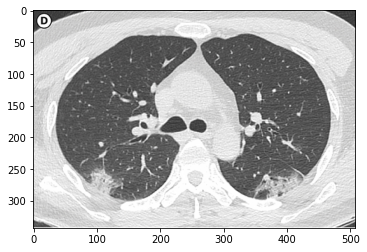

Predicted Class :  CT_COVID
*******************************************************


Test_Images\NOFinding_1.jpeg


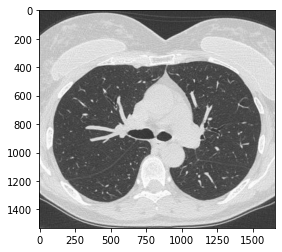

Predicted Class :  CT_NonCOVID
*******************************************************




In [148]:
test_files = np.array(glob("Test_Images/*"))

for file in test_files:   
    print(file)
    plt_img(file)
    print('*******************************************************')
    print("\n")